### Thanksgiving 2018

- started fire at 11 am using Minion method
- Placed turkey at 11:40 am
- vents fully open


In [48]:
import numpy,pandas
from collections import OrderedDict
import seaborn
import matplotlib.pyplot as plt

In [49]:
day='11-22-2018'
temptimes = OrderedDict({'11:42':[90,46],
            '11:43':[183,46],
            '11:46':[250,48],
            '11:52':[261,50],
            '12:03':[280,59]})

pdtimes = [pandas.to_datetime('%s %s'%(day,i), dayfirst=True) for i in temptimes]
internal = [temptimes[i][0] for i in temptimes]
air = [temptimes[i][1] for i in temptimes]

bbqdata = pandas.DataFrame({'air':air,'internal':internal},index=pdtimes)
bbqdata['time']=bbqdata.index
bbqdata_tidy = bbqdata.melt(value_vars=['air','internal'],
                            value_name='temperature',var_name='probe',
                           id_vars='time')


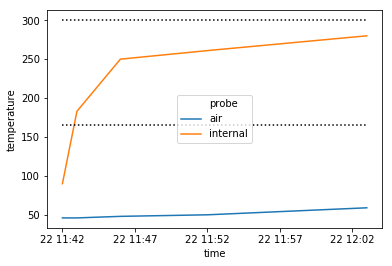

In [52]:
seaborn.lineplot(data=bbqdata_tidy,x='time',
               y='temperature',hue='probe')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[300,300],'k:')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[165,165],'k:')